In [ ]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import backend as K

**NumPy:** Supports numerical operations and array manipulations.

**Pandas:** Used for data manipulation and analysis.

**TensorFlow:** A deep learning framework for building and training neural networks.

**gc:** Handles garbage collection to clean up unused memory.

**Matplotlib & Seaborn:** Libraries for creating data visualizations.

**TensorFlow Keras:** Provides high-level APIs for building neural networks with ease.

**scikit-learn (sklearn):** Offers tools for model evaluation, including functions like confusion matrices.rices.

In [ ]:
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')
sys.stderr = open(os.devnull, 'w')

Suppress unnecessary warnings to make the code easier to understand and focus on the key aspects of how it works.

In [ ]:
img_height = 224
img_width = 224
batch_size = 4
data_dir = "/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset"
num_classes = 9
epochs = 100

In this section, we define key variables that are essential for the model’s accuracy, speed, and workload. Image height and width are particularly important. The original image resolution is 590x445. Reducing the image resolution improves the model’s speed but may slightly affect its accuracy. Using the original 590x445 resolution consumes more memory, which can slow down the model.

In Kaggle, notebooks have limited memory. If the model works with higher resolution images, it may run out of memory, causing the kernel to crash and restart. If you're using Google Colab or a local machine with more memory, you can increase the resolution without these issues.

The batch size variable defines how many images are sent to the model at a time. Increasing this value depends on the system’s memory. On Kaggle, we train with a batch size of 4 (i.e., 4 images at a time).

The data directory and number of classes variables are defined to point to our dataset and specify how many categories we're classifying.

The epochs variable defines how many times the model will cycle through the entire training data during training.



In [ ]:
image_paths = []
labels = []
class_names = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

for label in class_names:
    class_dir = os.path.join(data_dir, label, label)
    if os.path.exists(class_dir):
        for image_file in os.listdir(class_dir):
            image_paths.append(os.path.join(class_dir, image_file))
            labels.append(class_names.index(label))

data = pd.DataFrame({'image_path': image_paths, 'label': labels})
data = data.sample(frac=1, random_state=123).reset_index(drop=True)

train_size = int(0.8 * len(data))
train_data = data[:train_size]
val_data = data[train_size:]

def create_dataset(data_frame):
    image_paths = data_frame['image_path'].values
    labels = data_frame['label'].values
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    def load_and_preprocess_image(path, label):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [img_height, img_width])
        image = image / 255.0
        return image, label

    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=len(data_frame)).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

train_ds = create_dataset(train_data)
val_ds = create_dataset(val_data)

We start by gathering image paths and their corresponding labels. First, we obtain a list of class names from the dataset directory, filtering only directories that represent different classes. For each class, we build the path to the images and append the image paths and their respective labels to two lists.

Next, we create a DataFrame to store the image paths and their labels. We shuffle the dataset for randomness using pd.DataFrame.sample(), ensuring consistent results by setting a random_state. The dataset is then split into training data (80%) and validation data (20%).

The create_dataset() function is used to convert the DataFrame into a TensorFlow dataset. It extracts the image paths and labels, and then processes each image in the following way:

Reads the image file from the given path using tf.io.read_file().
Decodes the image and resizes it to the specified height and width.
Normalizes the image by scaling pixel values to the range [0, 1] by dividing by 255.0.
The dataset is then shuffled, batched, and pre-fetched to optimize training performance. We use tf.data.AUTOTUNE to dynamically tune the performance of the data pipeline.

Finally, we create the training dataset (train_ds) and validation dataset (val_ds) by passing the respective portions of data to the create_dataset() function.



In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(img_height, img_width, 3)),
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


**tf.keras.layers.Input(shape=(img_height, img_width, 3)):**
Specifies the input shape of the images, where img_height and img_width are the dimensions of the input image, and 3 corresponds to the RGB color channels.

**tf.keras.layers.Conv2D(16, 3, activation='relu'):**
This convolutional layer has 16 filters, each of size 3x3. It scans the input image to detect low-level features like edges. The ReLU activation function introduces non-linearity.

**tf.keras.layers.MaxPooling2D():**
A max-pooling layer reduces the spatial dimensions (height and width) by taking the maximum value from a window of the image. This helps in downsampling, reducing computational complexity while retaining important features.

**tf.keras.layers.Conv2D(32, 3, activation='relu'):**
Another convolutional layer with 32 filters. This layer captures more complex features as it processes the downsampled output from the previous layer.

**tf.keras.layers.MaxPooling2D():**
Again, max pooling reduces the spatial dimensions to help further downsample the image.

**tf.keras.layers.Flatten():**
Flattens the 2D matrix from the convolutional layers into a 1D vector, which is required before feeding it into fully connected layers.

**tf.keras.layers.Dense(64, activation='relu'):**
A dense layer with 64 neurons. This layer learns to combine the features extracted by the convolutional layers. The ReLU activation is applied again for non-linearity.

**tf.keras.layers.Dense(num_classes):**
The final dense layer has num_classes neurons, each corresponding to one of the possible output categories (the number of fish classes). This layer doesn't apply an activation function because logits are used.

**optimizer='adam':**
Adam (Adaptive Moment Estimation) is used as the optimizer. It adjusts the learning rate during training to ensure faster convergence and better performance.

**loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True):**
Sparse Categorical Crossentropy is used as the loss function, which is ideal for multi-class classification. Since the model outputs raw logits, we set from_logits=True.

**metrics=['accuracy']:**
Accuracy is used as the evaluation metric, which tracks the percentage of correct predictions during training and evaluation.

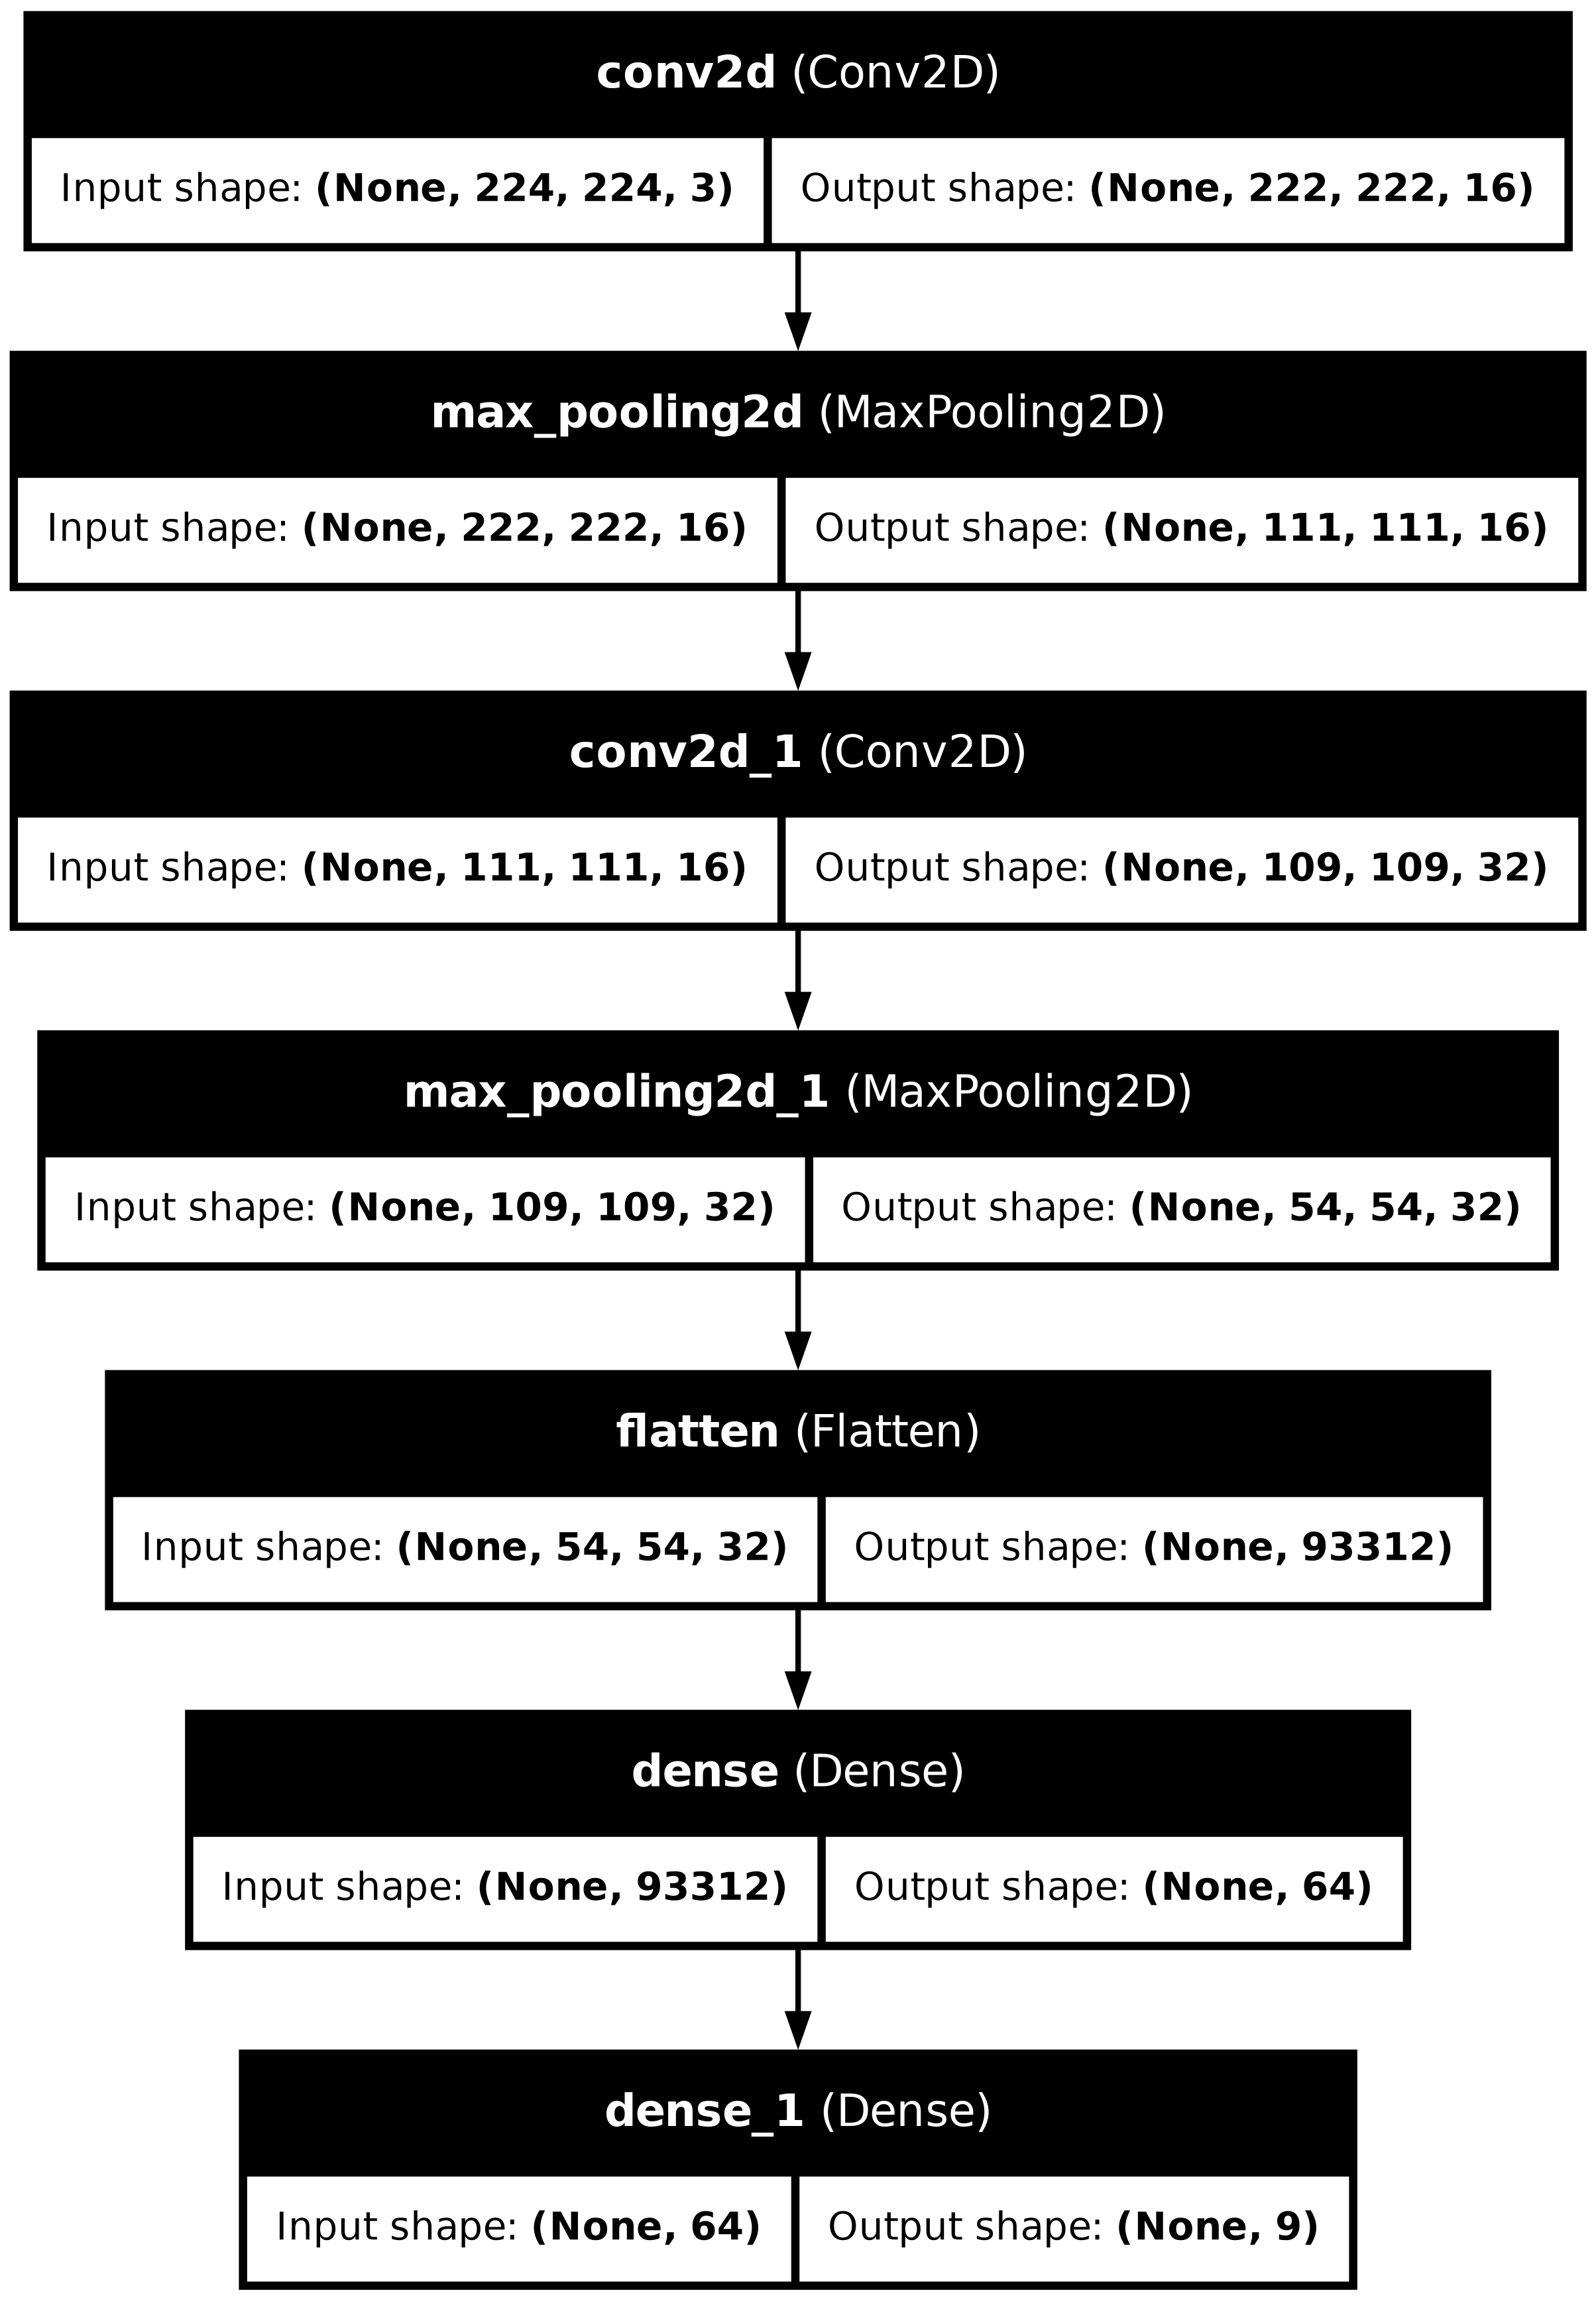

In [ ]:
class ClearMemory(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        K.clear_session()
        gc.collect()

This code defines a custom Keras callback called ClearMemory, which clears the session and performs garbage collection at the end of each training epoch.

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
        ClearMemory()  
    ]
)

This code defines the training process for our model using the model.fit() function and includes several important callbacks to optimize the training and manage resources effectively.

**Training Dataset (train_ds):**

This is our training data prepared earlier using create_dataset(). It contains the images and labels used to train the model.

**Validation Dataset (val_ds):**

This is the validation dataset, also created using create_dataset(). It is used to evaluate the model's performance on unseen data after each epoch.

**Epochs (epochs):**

Specifies the number of training cycles. Each epoch involves a full pass through the training dataset.

**Callbacks:**

Callbacks are functions that are executed at specific points during training (like at the end of each epoch) to monitor progress or adjust settings dynamically. Three callbacks are used here:

**EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True):**

Monitors the validation loss (val_loss). If the validation loss does not improve for 5 consecutive epochs (based on the patience parameter), training stops early to avoid overfitting and wasting time. The restore_best_weights=True option ensures that the model reverts to the weights from the best epoch where validation loss was the lowest.

**tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6):**

This callback reduces the learning rate when the model stops improving. If the validation loss doesn't improve for 3 epochs (patience=3), the learning rate will be reduced by a factor of 0.2. The min_lr=1e-6 ensures that the learning rate doesn’t drop below a certain threshold, preventing it from becoming too small.

**ClearMemory():**

This custom callback, which you defined earlier, clears the memory at the end of each epoch by resetting the backend session (K.clear_session()) and collecting unused memory (gc.collect()). This helps prevent memory overload during training, particularly in environments with limited resources, like Kaggle or Colab.


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
actual_epochs = len(history.history['accuracy'])
epochs_range = range(actual_epochs)

sns.set(style="whitegrid")
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color='blue', linewidth=2)
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='orange', linewidth=2)
plt.title('Training and Validation Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='lower right', fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color='blue', linewidth=2)
plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange', linewidth=2)
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right', fontsize=12)

plt.tight_layout()
plt.show()

This cell extracts the training and validation accuracy/loss from the model’s training history.
It plots the accuracy and loss over the number of epochs, helping visualize model performance during training.
Accuracy and loss are plotted side by side for better comparison.

In [ ]:
model.save('model.keras')

This saves the trained model to a file named model.keras, which can be loaded later for predictions or further training. This is important for preserving the model for future use.

In [ ]:
y_pred = []
y_true = []

for x_batch_val, y_batch_val in val_ds:
    preds = model.predict(x_batch_val, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(y_batch_val.numpy())

confusion_mtx = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.show()

This cell generates predictions for the validation dataset and compares them with true labels.
A confusion matrix is plotted to visualize the model's classification performance across different classes.
This helps in understanding which classes are correctly predicted and where the model may be making mistakes.


In [ ]:
classification_rep = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

classification_df = pd.DataFrame(classification_rep).transpose()

plt.figure(figsize=(10, 6))
sns.heatmap(classification_df.iloc[:-1, :-1], annot=True, cmap='Blues', fmt='.2f')
plt.title('Classification Report', fontsize=16)
plt.ylabel('Classes', fontsize=14)
plt.xlabel('Metrics', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

This cell generates a classification report that includes metrics like precision, recall, and F1-score for each class.
The report is converted to a Pandas DataFrame and visualized as a heatmap for a quick, visual overview of the model’s performance.
This provides a detailed evaluation of the model’s predictions, showing how well it performs on each class.
